# PixelSHAP: An In-Depth Usage Guide

This notebook provides a structured demonstration of how to use the `PixelSHAP` class.

---

## 1. Setup

Before running any examples, let's import the required libraries and initialize models.

## Important Update: Using Transformers for SAM2

This notebook has been updated to use SAM2 models from HuggingFace Transformers instead of local model files. The benefits include:

- **No local model files needed** - Models are automatically downloaded from HuggingFace
- **Easier setup** - No need to download and configure SAM2 checkpoints manually
- **Better compatibility** - Uses the official Transformers implementation
- **Same functionality** - All features work exactly the same as before

The models will be downloaded automatically on first use and cached for future runs.

In [37]:
import sys
from pathlib import Path

# Add the parent directory to the path to import token_shap modules
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from token_shap.base import OpenAIEmbeddings, OpenAIModel, LocalModel, HuggingFaceEmbeddings, OllamaModel, TfidfTextVectorizer
from token_shap.pixel_shap import PixelSHAP
from token_shap.image_utils import YoloSam2SegmentationModel, DinoSam2SegmentationModel, BlackoutSegmentationManipulator
from token_shap.visualization import visualize_segmentation_results

In [38]:
from token_shap.image_utils import YoloSam2SegmentationModel

In [40]:
# Initialize the segmentation model with Transformers SAM2
# The model will be automatically downloaded from HuggingFace

# Path to YOLO model (will be downloaded if not present)
YOLO_MODEL_PATH = "yolov8x.pt"

# Create segmentation model using Transformers SAM2 with optimized parameters
segmentation_model = YoloSam2SegmentationModel(
    yolo_model_path=YOLO_MODEL_PATH,
    sam2_model_id="facebook/sam2.1-hiera-large",  # Use HuggingFace model
    conf_threshold=0.2,
    device="cuda",
    use_yolov8=True,
    # Optimized parameters for better segmentation:
    # mask_threshold=0.0,  # Lower threshold for more complete masks
    # use_stability_score=True,  # Disable for better coverage
    # stability_score_thresh=0.95,  # Not used when disabled
    # remove_small_regions=True,  # Keep all regions for completeness
    # min_region_area=50,  # Smaller minimum area
    # # Overlap resolution - prevents same pixels assigned to multiple objects:
    # resolve_overlaps=True,  # Enable overlap resolution
    # overlap_resolution="score",  # Use IoU scores to resolve overlaps
    # # Mask selection strategy:
    # mask_selection="largest",  # Select the largest mask for better coverage
    # # Options: "iou" (best quality), "largest" (best coverage), "coverage" (best in bbox)
    # clip_to_bbox=True  # Keep masks within bounding boxes to avoid spillover
)

print("✓ Segmentation model initialized with optimized settings for better coverage")

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 14051.27it/s]


✓ Segmentation model initialized with optimized settings for better coverage



image 1/1 /home/ubuntu/TokenSHAP/notebooks/Screenshot 2025-09-21 at 17.07.11.png: 352x640 1 person, 5 cars, 2 trucks, 41.4ms
Speed: 1.2ms preprocess, 41.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


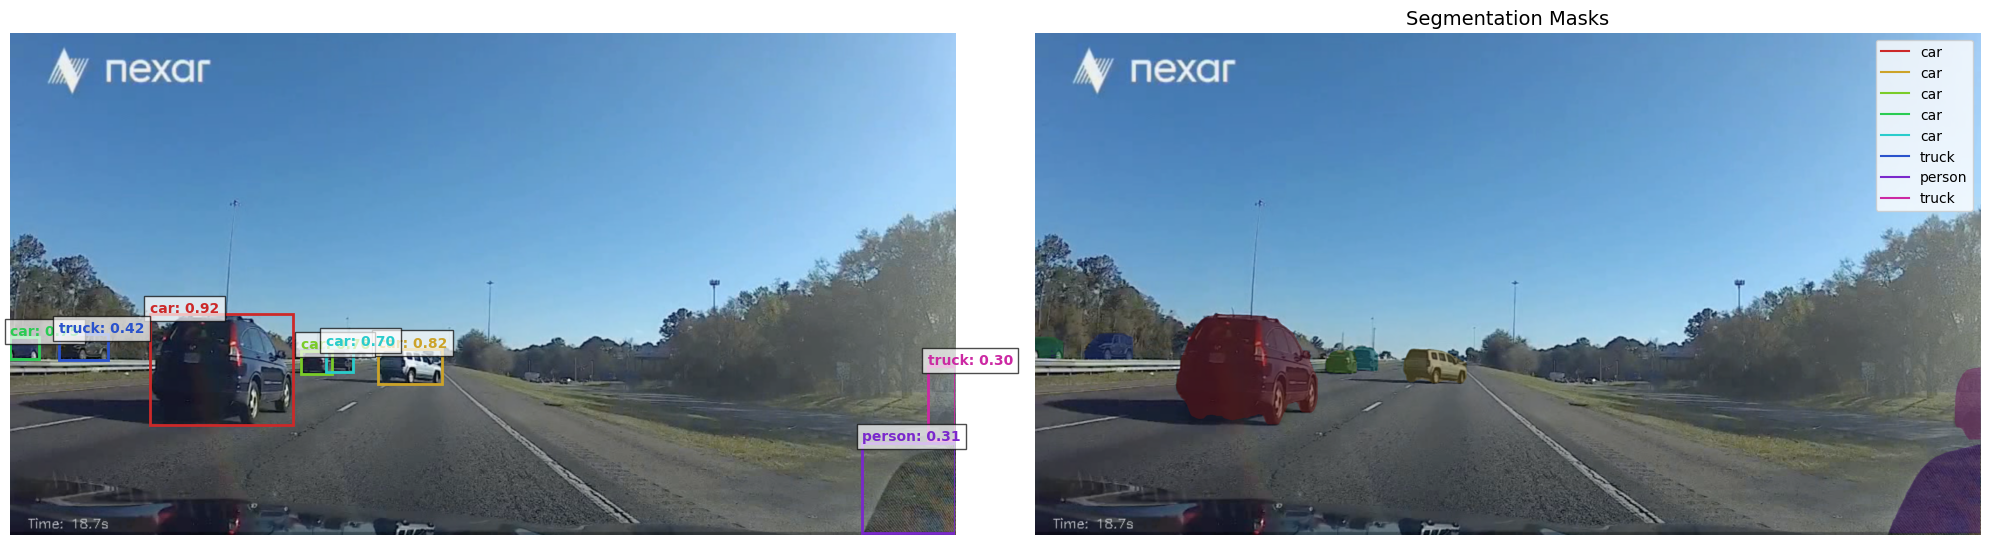

In [65]:
image_path = 'Screenshot 2025-09-21 at 17.07.11.png'
boxes, labels, confidences, masks = segmentation_model.segment(image_path=image_path)
visualize_segmentation_results(image_path, boxes, labels, confidences, masks)

In [66]:
# Alternative: Using Grounding DINO with SAM2 from Transformers
# Uncomment to use text-based object detection with Grounding DINO

# segmentation_model = DinoSam2SegmentationModel(
#     text_prompt="cartoon character, car",
#     sam2_model_id="facebook/sam2.1-hiera-large",  # Use HuggingFace SAM2 model
#     grounding_dino_model="IDEA-Research/grounding-dino-tiny",  # Use HuggingFace DINO model
#     device="cuda",
#     box_threshold=0.35,
#     text_threshold=0.3,
#     # Quality parameters:
#     mask_threshold=0.5,
#     use_stability_score=True,
#     stability_score_thresh=0.95,
#     remove_small_regions=True,
#     min_region_area=100,
#     # Overlap resolution:
#     resolve_overlaps=True,
#     overlap_resolution="score"
# )

In [67]:
#api_key = (..)

In [69]:
vlm = OpenAIModel(
    model_name='gpt-4o',
    api_key=api_key
)
openai_embedding = OpenAIEmbeddings(
    model="text-embedding-3-large", 
    api_key=api_key
)

manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

In [70]:
# vlm = OllamaModel(
#     model_name='llava:latest',
#     api_url='http://35.95.163.15:11434'
# )

# openai_embedding = OpenAIEmbeddings(
#     model="text-embedding-3-small", 
#     api_key=api_key
# )

# manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

In [71]:
# Create PixelSHAP analyzer
pixel_shap = PixelSHAP(
    model=vlm,
    segmentation_model=segmentation_model,
    manipulator=manipulator,
    vectorizer=openai_embedding,
    debug=True,
    temp_dir='example_temp',
)

In [72]:
# Analyze image
results_df, shapley_values = pixel_shap.analyze(
    image_path=image_path,
    prompt="Which vehicle loses control?",
    sampling_ratio=0.5,
    max_combinations=20,
    cleanup_temp_files=False
)


Starting analysis:
Image: Screenshot 2025-09-21 at 17.07.11.png
Prompt: Which vehicle loses control?

image 1/1 /home/ubuntu/TokenSHAP/notebooks/Screenshot 2025-09-21 at 17.07.11.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

Detected objects:
  0: car
  1: car
  2: car
  3: car
  4: car
  5: truck
  6: person
  7: truck
Number of samples: 8
Number of essential combinations: 8
Remaining combinations budget after essentials: 12
Number of additional combinations to sample: 12
Number of sampled combinations: 12
Total combinations to process: 20


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


Processing combination 1/20:
Combination: ['car_1', 'car_2', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7']
Indexes: (2, 3, 4, 5, 6, 7, 8)

Preparing combination:
  Showing: car_1, car_2, car_3, car_4, truck_5, person_6, truck_7
  Hiding: car_0
  Preserved indices: [1, 2, 3, 4, 5, 6, 7]


Processing combinations:   5%|▌         | 1/20 [00:02<00:56,  2.99s/it]

Received response for combination 1

Processing combination 2/20:
Combination: ['car_0', 'car_2', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7']
Indexes: (1, 3, 4, 5, 6, 7, 8)

Preparing combination:
  Showing: car_0, car_2, car_3, car_4, truck_5, person_6, truck_7
  Hiding: car_1
  Preserved indices: [0, 2, 3, 4, 5, 6, 7]


Processing combinations:  10%|█         | 2/20 [00:05<00:51,  2.85s/it]

Received response for combination 2

Processing combination 3/20:
Combination: ['car_0', 'car_1', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7']
Indexes: (1, 2, 4, 5, 6, 7, 8)

Preparing combination:
  Showing: car_0, car_1, car_3, car_4, truck_5, person_6, truck_7
  Hiding: car_2
  Preserved indices: [0, 1, 3, 4, 5, 6, 7]


Processing combinations:  15%|█▌        | 3/20 [00:08<00:45,  2.67s/it]

Received response for combination 3

Processing combination 4/20:
Combination: ['car_0', 'car_1', 'car_2', 'car_4', 'truck_5', 'person_6', 'truck_7']
Indexes: (1, 2, 3, 5, 6, 7, 8)

Preparing combination:
  Showing: car_0, car_1, car_2, car_4, truck_5, person_6, truck_7
  Hiding: car_3
  Preserved indices: [0, 1, 2, 4, 5, 6, 7]


Processing combinations:  20%|██        | 4/20 [00:14<01:04,  4.06s/it]

Received response for combination 4

Processing combination 5/20:
Combination: ['car_0', 'car_1', 'car_2', 'car_3', 'truck_5', 'person_6', 'truck_7']
Indexes: (1, 2, 3, 4, 6, 7, 8)

Preparing combination:
  Showing: car_0, car_1, car_2, car_3, truck_5, person_6, truck_7
  Hiding: car_4
  Preserved indices: [0, 1, 2, 3, 5, 6, 7]


Processing combinations:  25%|██▌       | 5/20 [00:19<01:07,  4.51s/it]

Received response for combination 5

Processing combination 6/20:
Combination: ['car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'person_6', 'truck_7']
Indexes: (1, 2, 3, 4, 5, 7, 8)

Preparing combination:
  Showing: car_0, car_1, car_2, car_3, car_4, person_6, truck_7
  Hiding: truck_5
  Preserved indices: [0, 1, 2, 3, 4, 6, 7]


Processing combinations:  30%|███       | 6/20 [00:22<00:52,  3.77s/it]

Received response for combination 6

Processing combination 7/20:
Combination: ['car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'truck_5', 'truck_7']
Indexes: (1, 2, 3, 4, 5, 6, 8)

Preparing combination:
  Showing: car_0, car_1, car_2, car_3, car_4, truck_5, truck_7
  Hiding: person_6
  Preserved indices: [0, 1, 2, 3, 4, 5, 7]


Processing combinations:  35%|███▌      | 7/20 [00:24<00:44,  3.42s/it]

Received response for combination 7

Processing combination 8/20:
Combination: ['car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'truck_5', 'person_6']
Indexes: (1, 2, 3, 4, 5, 6, 7)

Preparing combination:
  Showing: car_0, car_1, car_2, car_3, car_4, truck_5, person_6
  Hiding: truck_7
  Preserved indices: [0, 1, 2, 3, 4, 5, 6]


Processing combinations:  40%|████      | 8/20 [00:27<00:39,  3.28s/it]

Received response for combination 8

Processing combination 9/20:
Combination: ('car_0', 'car_2', 'truck_5', 'truck_7')
Indexes: (1, 3, 6, 8)

Preparing combination:
  Showing: car_0, car_2, truck_5, truck_7
  Hiding: car_1, car_3, car_4, person_6
  Preserved indices: [0, 2, 5, 7]


Processing combinations:  45%|████▌     | 9/20 [00:29<00:32,  2.95s/it]

Received response for combination 9

Processing combination 10/20:
Combination: ('car_1', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7')
Indexes: (2, 4, 5, 6, 7, 8)

Preparing combination:
  Showing: car_1, car_3, car_4, truck_5, person_6, truck_7
  Hiding: car_0, car_2
  Preserved indices: [1, 3, 4, 5, 6, 7]


Processing combinations:  50%|█████     | 10/20 [00:32<00:29,  2.91s/it]

Received response for combination 10

Processing combination 11/20:
Combination: ('car_1', 'car_2', 'car_3')
Indexes: (2, 3, 4)

Preparing combination:
  Showing: car_1, car_2, car_3
  Hiding: car_0, car_4, truck_5, person_6, truck_7
  Preserved indices: [1, 2, 3]


Processing combinations:  55%|█████▌    | 11/20 [00:37<00:30,  3.42s/it]

Received response for combination 11

Processing combination 12/20:
Combination: ('car_0', 'car_2', 'person_6', 'truck_7')
Indexes: (1, 3, 7, 8)

Preparing combination:
  Showing: car_0, car_2, person_6, truck_7
  Hiding: car_1, car_3, car_4, truck_5
  Preserved indices: [0, 2, 6, 7]


Processing combinations:  60%|██████    | 12/20 [00:39<00:23,  2.91s/it]

Received response for combination 12

Processing combination 13/20:
Combination: ('car_0', 'car_3', 'car_4', 'truck_7')
Indexes: (1, 4, 5, 8)

Preparing combination:
  Showing: car_0, car_3, car_4, truck_7
  Hiding: car_1, car_2, truck_5, person_6
  Preserved indices: [0, 3, 4, 7]


Processing combinations:  65%|██████▌   | 13/20 [00:41<00:19,  2.81s/it]

Received response for combination 13

Processing combination 14/20:
Combination: ('car_4', 'person_6', 'truck_7')
Indexes: (5, 7, 8)

Preparing combination:
  Showing: car_4, person_6, truck_7
  Hiding: car_0, car_1, car_2, car_3, truck_5
  Preserved indices: [4, 6, 7]


Processing combinations:  70%|███████   | 14/20 [00:43<00:15,  2.67s/it]

Received response for combination 14

Processing combination 15/20:
Combination: ('car_2', 'car_3', 'car_4', 'truck_5')
Indexes: (3, 4, 5, 6)

Preparing combination:
  Showing: car_2, car_3, car_4, truck_5
  Hiding: car_0, car_1, person_6, truck_7
  Preserved indices: [2, 3, 4, 5]


Processing combinations:  75%|███████▌  | 15/20 [00:46<00:12,  2.47s/it]

Received response for combination 15

Processing combination 16/20:
Combination: ('car_0', 'car_2', 'car_4', 'person_6', 'truck_7')
Indexes: (1, 3, 5, 7, 8)

Preparing combination:
  Showing: car_0, car_2, car_4, person_6, truck_7
  Hiding: car_1, car_3, truck_5
  Preserved indices: [0, 2, 4, 6, 7]


Processing combinations:  80%|████████  | 16/20 [00:48<00:09,  2.44s/it]

Received response for combination 16

Processing combination 17/20:
Combination: ('car_0', 'car_1', 'car_3', 'car_4', 'person_6', 'truck_7')
Indexes: (1, 2, 4, 5, 7, 8)

Preparing combination:
  Showing: car_0, car_1, car_3, car_4, person_6, truck_7
  Hiding: car_2, truck_5
  Preserved indices: [0, 1, 3, 4, 6, 7]


Processing combinations:  85%|████████▌ | 17/20 [00:50<00:07,  2.39s/it]

Received response for combination 17

Processing combination 18/20:
Combination: ('car_0', 'car_2', 'car_4', 'person_6')
Indexes: (1, 3, 5, 7)

Preparing combination:
  Showing: car_0, car_2, car_4, person_6
  Hiding: car_1, car_3, truck_5, truck_7
  Preserved indices: [0, 2, 4, 6]


Processing combinations:  90%|█████████ | 18/20 [00:52<00:04,  2.22s/it]

Received response for combination 18

Processing combination 19/20:
Combination: ('car_0', 'car_1', 'truck_7')
Indexes: (1, 2, 8)

Preparing combination:
  Showing: car_0, car_1, truck_7
  Hiding: car_2, car_3, car_4, truck_5, person_6
  Preserved indices: [0, 1, 7]


Processing combinations:  95%|█████████▌| 19/20 [00:55<00:02,  2.53s/it]

Received response for combination 19

Processing combination 20/20:
Combination: ('car_3', 'person_6')
Indexes: (4, 7)

Preparing combination:
  Showing: car_3, person_6
  Hiding: car_0, car_1, car_2, car_4, truck_5, truck_7
  Preserved indices: [3, 6]


Processing combinations: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]

Received response for combination 20



DataFrame summary:

Combination_Key: combination_2,3,4,5,6,7,8
  Content: ['car_1', 'car_2', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7'] | Hidden: ['car_0']
  Similarity: 0.883

Combination_Key: combination_1,3,4,5,6,7,8
  Content: ['car_0', 'car_2', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7'] | Hidden: ['car_1']
  Similarity: 0.604

Combination_Key: combination_1,2,4,5,6,7,8
  Content: ['car_0', 'car_1', 'car_3', 'car_4', 'truck_5', 'person_6', 'truck_7'] | Hidden: ['car_2']
  Similarity: 0.873

Combination_Key: combination_1,2,3,5,6,7,8
  Content: ['car_0', 'car_1', 'car_2', 'car_4', 'truck_5', 'person_6', 'truck_7'] | Hidden: ['car_3']
  Similarity: 0.862

Combination_Key: combination_1,2,3,4,6,7,8
  Content: ['car_0', 'car_1', 'car_2', 'car_3', 'truck_5', 'person_6', 'truck_7'] | Hidden: ['car_4']
  Similarity: 0.817

Combination_Key: combination_1,2,3,4,5,7,8
  Content: ['car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'person_6', 'truck_7'] | Hidden: ['truck_5']
  Si

In [73]:
results_df.head()

,Combination_Key,Used_Combination,Hidden_Objects,Response,Indexes,Similarity
0,"combination_2,3,4,5,6,7,8","[car_1, car_2, car_3, car_4, truck_5, person_6...",[car_0],The white SUV in the middle of the image appea...,"(2, 3, 4, 5, 6, 7, 8)",0.883438
1,"combination_1,3,4,5,6,7,8","[car_0, car_2, car_3, car_4, truck_5, person_6...",[car_1],I can't determine which vehicle loses control ...,"(1, 3, 4, 5, 6, 7, 8)",0.603825
2,"combination_1,2,4,5,6,7,8","[car_0, car_1, car_3, car_4, truck_5, person_6...",[car_2],The white SUV on the right side of the image a...,"(1, 2, 4, 5, 6, 7, 8)",0.873283
3,"combination_1,2,3,5,6,7,8","[car_0, car_1, car_2, car_4, truck_5, person_6...",[car_3],"The white SUV on the right is losing control, ...","(1, 2, 3, 5, 6, 7, 8)",0.861562
4,"combination_1,2,3,4,6,7,8","[car_0, car_1, car_2, car_3, truck_5, person_6...",[car_4],The white SUV in the right lane is the one los...,"(1, 2, 3, 4, 6, 7, 8)",0.817305



image 1/1 /home/ubuntu/TokenSHAP/notebooks/Screenshot 2025-09-21 at 17.07.11.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

Detected objects:
  0: car
  1: car
  2: car
  3: car
  4: car
  5: truck
  6: person
  7: truck


/home/ubuntu/TokenSHAP/token_shap/visualization.py:799: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1014: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


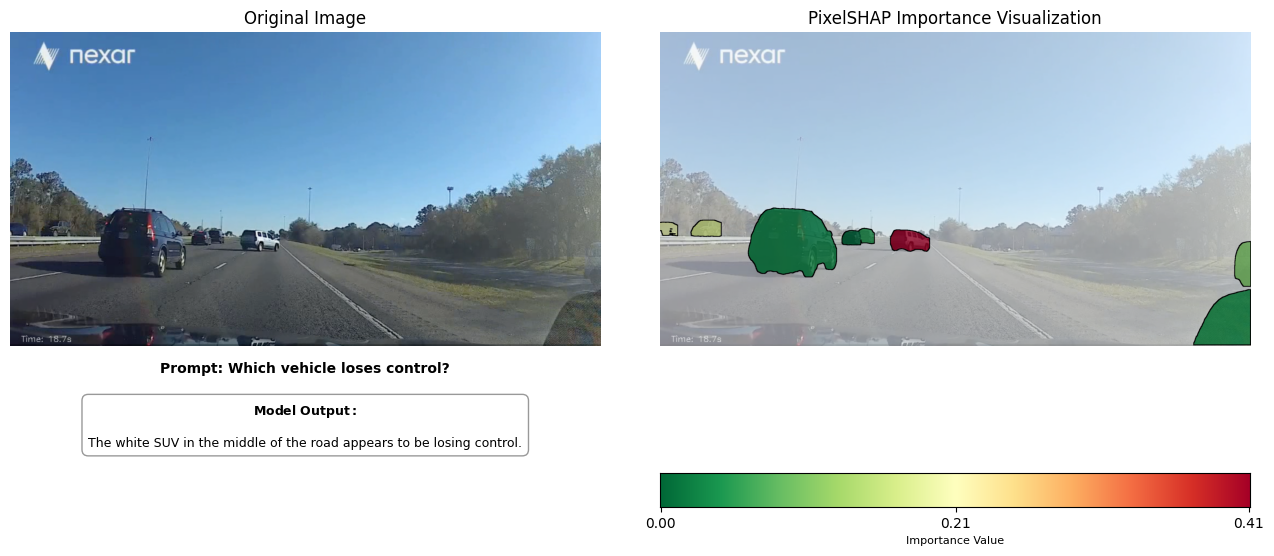

In [74]:
pixel_shap.visualize(
    background_opacity=0.5,
    show_original_side_by_side=True,
    show_labels=False,
    show_model_output=True
)


image 1/1 /home/ubuntu/TokenSHAP/notebooks/Screenshot 2025-09-21 at 17.07.11.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

Detected objects:
  0: car
  1: car
  2: car
  3: car
  4: car
  5: truck
  6: person
  7: truck


/home/ubuntu/TokenSHAP/token_shap/visualization.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


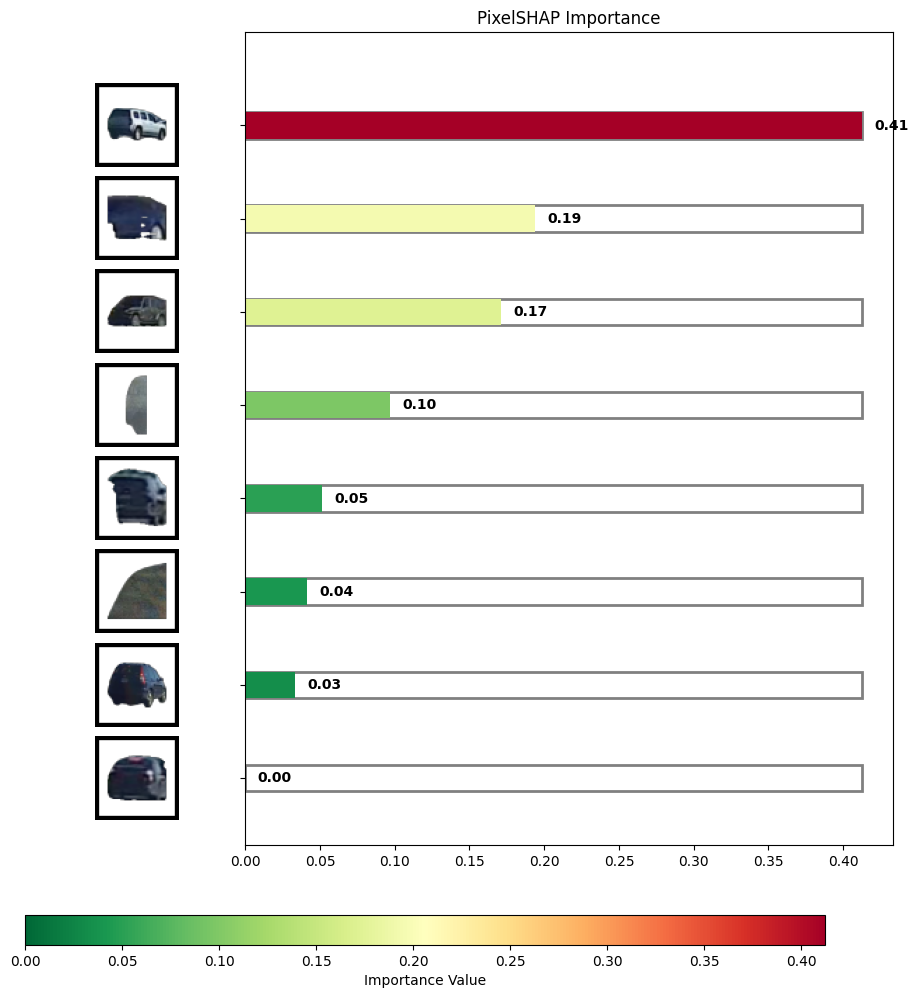

In [75]:
sorted_items = pixel_shap.plot_importance_ranking(thumbnail_size=10)

## 2. Using OpenAI API Models

We start by using OpenAI's API to analyze token contributions in different scenarios.

Now we can analyze the prompt:

In [ ]:
prompt4 = "What are the symptoms of COVID-19?"
df_local = token_shap_local.analyze(prompt4, sampling_ratio=0.0, print_highlight_text=True)
token_shap_local.print_colored_text()

In [ ]:
df_local

In [ ]:
token_shap_local.highlight_text_background()

In [ ]:
token_shap_local.print_colored_text()

In [ ]:
token_shap_local.plot_colored_text()

In [ ]:
ollama_model = OllamaModel(model_name="llama3.2-vision:latest", api_url="http://35.95.163.15:11434")
tfidf_embedding = TfidfTextVectorizer()
token_shap_ollama = TokenSHAP(model=ollama_model, splitter=splitter, vectorizer=tfidf_embedding)

In [ ]:
prompt5 = "Explain quantum mechanics in simple terms."
df_ollama = token_shap_ollama.analyze(prompt5, sampling_ratio=0.5, print_highlight_text=True)
token_shap_ollama.print_colored_text()

Sentence-Level Splitting
For more advanced analysis, you might want to split the prompt into sentences rather than words. You can customized the splitter for this purpose.

In [ ]:
openai_model = OpenAIModel(api_key=api_key)
openai_embedding = OpenAIEmbeddings(api_key=api_key)
splitter = StringSplitter(split_pattern='\.')
token_shap_openai = TokenSHAP(model=openai_model, splitter=splitter, vectorizer=openai_embedding)

In [ ]:
prompt = """Our company is experiencing a decline in quarterly sales for the first time in five years.
Recent market trends indicate increased competition from new startups offering similar products at lower prices.
Despite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter.
In addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products.
Our largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base.
What strategic actions should our company consider to regain market share and improve customer satisfaction?
"""

#### Output Explanation:

The analysis will consider each sentence as a token, allowing you to understand the importance of each sentence in generating the model's response.

In [ ]:
splitter.split(prompt)

In [ ]:
df_sentence = token_shap_openai.analyze(prompt, sampling_ratio=0.5)

In [ ]:
len(df_sentence)

In [ ]:
df_sentence.head()

In [ ]:
token_shap_openai.plot_colored_text(new_line = True)

In [ ]:
token_shap_openai.print_colored_text()

In [ ]:
token_shap_openai.highlight_text_background()